In [2]:
import nltk
from nltk.corpus import stopwords
stop_words=set(stopwords.words('english'))
from nltk import pos_tag

import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

import pandas as pd

import re

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics.classification import classification_report, accuracy_score

import emoji
from emoji.unicode_codes import UNICODE_EMOJI

from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

from sklearn import preprocessing

from wordcloud import WordCloud, STOPWORDS 
from textblob import TextBlob

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split

from gensim.models import Word2Vec

import itertools

In [3]:
path = '/Users/pritigirishvankudre/Day9_Hackathon2/Twitter Sentiment/train.csv'
dataset = pd.read_csv(path)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7274 entries, 0 to 7273
Data columns (total 3 columns):
tweet_id     7274 non-null int64
tweet        7273 non-null object
sentiment    7274 non-null int64
dtypes: int64(2), object(1)
memory usage: 170.6+ KB


In [4]:
dataset.head()

,tweet_id,tweet,sentiment
0,1701,#sxswnui #sxsw #apple defining language of tou...,1
1,1851,Learning ab Google doodles! All doodles should...,1
2,2689,one of the most in-your-face ex. of stealing t...,2
3,4525,This iPhone #SXSW app would b pretty awesome i...,0
4,3604,Line outside the Apple store in Austin waiting...,1


South by Southwest (abbreviated as SXSW and colloquially referred to as South By) is an annual
conglomeration of parallel film, interactive media, and music festivals and conferences organized jointly
that take place in mid-March in Austin, Texas, United States. 

So we could expect tweets about film, music, media, festival, places around it, hotels, food joints, relevant apps
either promoting, criticising, just broadcasting information etc.

As per objective mentioned in the problem statement we need to gain the pulse of competing products and the associated sentiment from social media

In [5]:
'''
Mehtod to understand Null values distribution
'''
col_null = pd.DataFrame(dataset.isnull().sum()).reset_index()
col_null.columns = ['DataColumns','NullCount']
col_null['NullCount_Pct'] = round((col_null['NullCount']/dataset.shape[0])*100,2)
display (col_null)

,DataColumns,NullCount,NullCount_Pct
0,tweet_id,0,0.00
1,tweet,1,0.01
2,sentiment,0,0.00


In [6]:
'''
Method to understand Unique values distribution
'''
col_uniq = pd.DataFrame(dataset.nunique()).reset_index()
col_uniq.columns = ['DataColumns','UniqCount']
col_uniq_cnt = pd.DataFrame(dataset.count(axis=0)).reset_index()
col_uniq_cnt.columns = ['DataColumns','UniqCount']
col_uniq['UniqCount_Pct'] = round((col_uniq['UniqCount']/col_uniq_cnt['UniqCount'])*100,4)
display (col_uniq)

,DataColumns,UniqCount,UniqCount_Pct
0,tweet_id,7274,100.0000
1,tweet,7255,99.7525
2,sentiment,4,0.0550


It shows 19 duplicate sentiments but at this moment we will ignore these duplicate tweets.

In [7]:
# removing null tweets from the data
dataset.dropna(axis=0,inplace=True)
dataset['tweet'].isnull().sum()

0

In [8]:
# trasforming data to lower case
dataset['tweet'] = dataset['tweet'].apply(lambda x: x.lower())
dataset.head(15)

,tweet_id,tweet,sentiment
0,1701,#sxswnui #sxsw #apple defining language of tou...,1
1,1851,learning ab google doodles! all doodles should...,1
2,2689,one of the most in-your-face ex. of stealing t...,2
3,4525,this iphone #sxsw app would b pretty awesome i...,0
4,3604,line outside the apple store in austin waiting...,1
5,966,#technews one lone dude awaits ipad 2 at apple...,1
6,1395,"sxsw tips, prince, npr videos, toy shopping wi...",1
7,8182,nu user rt @mention new #ubersocial for #iphon...,1
8,8835,free #sxsw sampler on itunes {link} #freemusic,2
9,883,i think i might go all weekend without seeing ...,2


In [9]:
# converting emoji to text/sentiment

dataset['tweet'] = dataset['tweet'].apply(lambda x: emoji.demojize(x))
#dataset['tweet'] = dataset['tweet'].apply(lambda x: re.sub(':','',x))
dataset['tweet'] = dataset['tweet'].str.replace(r':','')

In [10]:
# removing twitter user name (@mention)

#dataset['tweet'] = dataset['tweet'].apply(lambda x: re.sub('(@[\w]*)','',x))
dataset['tweet'] = dataset['tweet'].str.replace(r'(@[\w]*)','')
dataset.head(15)

,tweet_id,tweet,sentiment
0,1701,#sxswnui #sxsw #apple defining language of tou...,1
1,1851,learning ab google doodles! all doodles should...,1
2,2689,one of the most in-your-face ex. of stealing t...,2
3,4525,this iphone #sxsw app would b pretty awesome i...,0
4,3604,line outside the apple store in austin waiting...,1
5,966,#technews one lone dude awaits ipad 2 at apple...,1
6,1395,"sxsw tips, prince, npr videos, toy shopping wi...",1
7,8182,nu user rt new #ubersocial for #iphone now in...,1
8,8835,free #sxsw sampler on itunes {link} #freemusic,2
9,883,i think i might go all weekend without seeing ...,2


In [11]:
# removing punctuation
dataset['tweet'] = dataset['tweet'].str.replace(r'[^a-zA-Z0-9# ]','')
dataset.head(15)

,tweet_id,tweet,sentiment
0,1701,#sxswnui #sxsw #apple defining language of tou...,1
1,1851,learning ab google doodles all doodles should ...,1
2,2689,one of the most inyourface ex of stealing the ...,2
3,4525,this iphone #sxsw app would b pretty awesome i...,0
4,3604,line outside the apple store in austin waiting...,1
5,966,#technews one lone dude awaits ipad 2 at apple...,1
6,1395,sxsw tips prince npr videos toy shopping with ...,1
7,8182,nu user rt new #ubersocial for #iphone now in...,1
8,8835,free #sxsw sampler on itunes link #freemusic,2
9,883,i think i might go all weekend without seeing ...,2


In [12]:
# stop words: removing stop words
dataset['clean_tweet'] = dataset['tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
dataset.head(15)

,tweet_id,tweet,sentiment,clean_tweet
0,1701,#sxswnui #sxsw #apple defining language of tou...,1,#sxswnui #sxsw #apple defining language touch ...
1,1851,learning ab google doodles all doodles should ...,1,learning ab google doodles doodles light funny...
2,2689,one of the most inyourface ex of stealing the ...,2,one inyourface ex stealing show yrs rt quotat ...
3,4525,this iphone #sxsw app would b pretty awesome i...,0,iphone #sxsw app would b pretty awesome didnt ...
4,3604,line outside the apple store in austin waiting...,1,line outside apple store austin waiting new ip...
5,966,#technews one lone dude awaits ipad 2 at apple...,1,#technews one lone dude awaits ipad 2 apples s...
6,1395,sxsw tips prince npr videos toy shopping with ...,1,sxsw tips prince npr videos toy shopping zucke...
7,8182,nu user rt new #ubersocial for #iphone now in...,1,nu user rt new #ubersocial #iphone app store i...
8,8835,free #sxsw sampler on itunes link #freemusic,2,free #sxsw sampler itunes link #freemusic
9,883,i think i might go all weekend without seeing ...,2,think might go weekend without seeing ipad cas...


In [13]:
# Tokenize: Split the sentence into words
dataset['clean_tweet'].apply(lambda x: nltk.word_tokenize(x))

# Lemmatize list of words and join
dataset['clean_tweet'].apply(lambda x: ' '.join([lemmatizer.lemmatize(x)]))
dataset.head(15)

,tweet_id,tweet,sentiment,clean_tweet
0,1701,#sxswnui #sxsw #apple defining language of tou...,1,#sxswnui #sxsw #apple defining language touch ...
1,1851,learning ab google doodles all doodles should ...,1,learning ab google doodles doodles light funny...
2,2689,one of the most inyourface ex of stealing the ...,2,one inyourface ex stealing show yrs rt quotat ...
3,4525,this iphone #sxsw app would b pretty awesome i...,0,iphone #sxsw app would b pretty awesome didnt ...
4,3604,line outside the apple store in austin waiting...,1,line outside apple store austin waiting new ip...
5,966,#technews one lone dude awaits ipad 2 at apple...,1,#technews one lone dude awaits ipad 2 apples s...
6,1395,sxsw tips prince npr videos toy shopping with ...,1,sxsw tips prince npr videos toy shopping zucke...
7,8182,nu user rt new #ubersocial for #iphone now in...,1,nu user rt new #ubersocial #iphone app store i...
8,8835,free #sxsw sampler on itunes link #freemusic,2,free #sxsw sampler itunes link #freemusic
9,883,i think i might go all weekend without seeing ...,2,think might go weekend without seeing ipad cas...


In [14]:
# removing hashtag from clean_tweet
dataset['clean_tweet'] = dataset['clean_tweet'].str.replace("[^a-zA-Z0-9 ]",'')
dataset.head(15)

,tweet_id,tweet,sentiment,clean_tweet
0,1701,#sxswnui #sxsw #apple defining language of tou...,1,sxswnui sxsw apple defining language touch dif...
1,1851,learning ab google doodles all doodles should ...,1,learning ab google doodles doodles light funny...
2,2689,one of the most inyourface ex of stealing the ...,2,one inyourface ex stealing show yrs rt quotat ...
3,4525,this iphone #sxsw app would b pretty awesome i...,0,iphone sxsw app would b pretty awesome didnt c...
4,3604,line outside the apple store in austin waiting...,1,line outside apple store austin waiting new ip...
5,966,#technews one lone dude awaits ipad 2 at apple...,1,technews one lone dude awaits ipad 2 apples sx...
6,1395,sxsw tips prince npr videos toy shopping with ...,1,sxsw tips prince npr videos toy shopping zucke...
7,8182,nu user rt new #ubersocial for #iphone now in...,1,nu user rt new ubersocial iphone app store inc...
8,8835,free #sxsw sampler on itunes link #freemusic,2,free sxsw sampler itunes link freemusic
9,883,i think i might go all weekend without seeing ...,2,think might go weekend without seeing ipad cas...


In [15]:
#extracting retweet in separate column
pattern = re.compile(r'(^rt)')
dataset['retweet'] = dataset['tweet'].apply(lambda x: str(re.findall(pattern,x)))
dataset['retweet'] = dataset['retweet'].astype('category').cat.codes
dataset['retweet'].replace([1,0],[0,1],inplace=True)
dataset['clean_tweet'] = dataset['clean_tweet'].str.replace(r'(^rt)','')
dataset.head(15)

,tweet_id,tweet,sentiment,clean_tweet,retweet
0,1701,#sxswnui #sxsw #apple defining language of tou...,1,sxswnui sxsw apple defining language touch dif...,0
1,1851,learning ab google doodles all doodles should ...,1,learning ab google doodles doodles light funny...,0
2,2689,one of the most inyourface ex of stealing the ...,2,one inyourface ex stealing show yrs rt quotat ...,0
3,4525,this iphone #sxsw app would b pretty awesome i...,0,iphone sxsw app would b pretty awesome didnt c...,0
4,3604,line outside the apple store in austin waiting...,1,line outside apple store austin waiting new ip...,0
5,966,#technews one lone dude awaits ipad 2 at apple...,1,technews one lone dude awaits ipad 2 apples sx...,0
6,1395,sxsw tips prince npr videos toy shopping with ...,1,sxsw tips prince npr videos toy shopping zucke...,0
7,8182,nu user rt new #ubersocial for #iphone now in...,1,nu user rt new ubersocial iphone app store inc...,0
8,8835,free #sxsw sampler on itunes link #freemusic,2,free sxsw sampler itunes link freemusic,0
9,883,i think i might go all weekend without seeing ...,2,think might go weekend without seeing ipad cas...,0


In [16]:
#extracting hashtag words in separate columns
pattern = re.compile(r'(#[\w]*)')
dataset['hashtag'] = dataset['tweet'].apply(lambda x: re.findall(pattern,x))
dataset['clean_hashtag'] = dataset['hashtag'].apply(lambda x: " ".join(x))
#dataset['clean_hashtag'] = dataset['clean_hashtag'].apply(lambda x: re.sub("[^a-zA-Z0-9 ]",'',x))
dataset['clean_hashtag'] = dataset['clean_hashtag'].str.replace(r"[^a-zA-Z0-9 ]",'')
dataset.drop('hashtag',axis=1,inplace=True)
dataset.head(15)

,tweet_id,tweet,sentiment,clean_tweet,retweet,clean_hashtag
0,1701,#sxswnui #sxsw #apple defining language of tou...,1,sxswnui sxsw apple defining language touch dif...,0,sxswnui sxsw apple
1,1851,learning ab google doodles all doodles should ...,1,learning ab google doodles doodles light funny...,0,googledoodle sxsw
2,2689,one of the most inyourface ex of stealing the ...,2,one inyourface ex stealing show yrs rt quotat ...,0,sxsw
3,4525,this iphone #sxsw app would b pretty awesome i...,0,iphone sxsw app would b pretty awesome didnt c...,0,sxsw fuckit illmakeitwork
4,3604,line outside the apple store in austin waiting...,1,line outside apple store austin waiting new ip...,0,sxsw
5,966,#technews one lone dude awaits ipad 2 at apple...,1,technews one lone dude awaits ipad 2 apples sx...,0,technews technews apple ipad2 sxsw tablets tech
6,1395,sxsw tips prince npr videos toy shopping with ...,1,sxsw tips prince npr videos toy shopping zucke...,0,sxsw ipad
7,8182,nu user rt new #ubersocial for #iphone now in...,1,nu user rt new ubersocial iphone app store inc...,0,ubersocial iphone sxsw mashable
8,8835,free #sxsw sampler on itunes link #freemusic,2,free sxsw sampler itunes link freemusic,0,sxsw freemusic
9,883,i think i might go all weekend without seeing ...,2,think might go weekend without seeing ipad cas...,0,sxsw


In [17]:
#removing common words which are of no importance to analysis
dataset['clean_tweet'] = dataset['clean_tweet'].str.replace(r"\w*\d*(sxsw)\d*\w*",'')
dataset['clean_tweet'] = dataset['clean_tweet'].str.replace(r"\w*\d*(austin)\d*\w*",'')
dataset['clean_tweet'] = dataset['clean_tweet'].str.replace(r"\w*\d*(texas)\d*\w*",'')
dataset.head(15)

,tweet_id,tweet,sentiment,clean_tweet,retweet,clean_hashtag
0,1701,#sxswnui #sxsw #apple defining language of tou...,1,apple defining language touch different dial...,0,sxswnui sxsw apple
1,1851,learning ab google doodles all doodles should ...,1,learning ab google doodles doodles light funny...,0,googledoodle sxsw
2,2689,one of the most inyourface ex of stealing the ...,2,one inyourface ex stealing show yrs rt quotat ...,0,sxsw
3,4525,this iphone #sxsw app would b pretty awesome i...,0,iphone app would b pretty awesome didnt crash...,0,sxsw fuckit illmakeitwork
4,3604,line outside the apple store in austin waiting...,1,line outside apple store waiting new ipad link,0,sxsw
5,966,#technews one lone dude awaits ipad 2 at apple...,1,technews one lone dude awaits ipad 2 apples s...,0,technews technews apple ipad2 sxsw tablets tech
6,1395,sxsw tips prince npr videos toy shopping with ...,1,tips prince npr videos toy shopping zuckerber...,0,sxsw ipad
7,8182,nu user rt new #ubersocial for #iphone now in...,1,nu user rt new ubersocial iphone app store inc...,0,ubersocial iphone sxsw mashable
8,8835,free #sxsw sampler on itunes link #freemusic,2,free sampler itunes link freemusic,0,sxsw freemusic
9,883,i think i might go all weekend without seeing ...,2,think might go weekend without seeing ipad cas...,0,sxsw


In [18]:
dataset['clean_hashtag'] = dataset['clean_hashtag'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
dataset['clean_hashtag'] = dataset['clean_hashtag'].str.replace(r"\w*\d*(sxsw)\d*\w*",'')
dataset['clean_hashtag'] = dataset['clean_hashtag'].str.replace(r"\w*\d*(austin)\d*\w*",'')
dataset['clean_hashtag'] = dataset['clean_hashtag'].str.replace(r"\w*\d*(texas)\d*\w*",'')
dataset.head(15)

,tweet_id,tweet,sentiment,clean_tweet,retweet,clean_hashtag
0,1701,#sxswnui #sxsw #apple defining language of tou...,1,apple defining language touch different dial...,0,apple
1,1851,learning ab google doodles all doodles should ...,1,learning ab google doodles doodles light funny...,0,googledoodle
2,2689,one of the most inyourface ex of stealing the ...,2,one inyourface ex stealing show yrs rt quotat ...,0,
3,4525,this iphone #sxsw app would b pretty awesome i...,0,iphone app would b pretty awesome didnt crash...,0,fuckit illmakeitwork
4,3604,line outside the apple store in austin waiting...,1,line outside apple store waiting new ipad link,0,
5,966,#technews one lone dude awaits ipad 2 at apple...,1,technews one lone dude awaits ipad 2 apples s...,0,technews technews apple ipad2 tablets tech
6,1395,sxsw tips prince npr videos toy shopping with ...,1,tips prince npr videos toy shopping zuckerber...,0,ipad
7,8182,nu user rt new #ubersocial for #iphone now in...,1,nu user rt new ubersocial iphone app store inc...,0,ubersocial iphone mashable
8,8835,free #sxsw sampler on itunes link #freemusic,2,free sampler itunes link freemusic,0,freemusic
9,883,i think i might go all weekend without seeing ...,2,think might go weekend without seeing ipad cas...,0,


In [19]:
#Finding noun/adjective from clean tweet
def get_NounList(text):
    tb=TextBlob(text)
    nounlist=[]
    for word,pos in tb.tags:
        if pos == 'NN':
            nounlist.append(word)
    nounlist=" ".join(word for word in nounlist)
    return nounlist

def get_AdjList(text):
    tb=TextBlob(text)
    adjlist=[]
    for word,pos in tb.tags:
        if pos == 'JJ':
            adjlist.append(word)
    adjlist=" ".join(word for word in adjlist)
    return adjlist



dataset['tweet_noun'] = dataset['clean_tweet'].apply(lambda x: get_NounList(x))
dataset['tweet_adj'] = dataset['clean_tweet'].apply(lambda x: get_AdjList(x))
dataset.head(15)

,tweet_id,tweet,sentiment,clean_tweet,retweet,clean_hashtag,tweet_noun,tweet_adj
0,1701,#sxswnui #sxsw #apple defining language of tou...,1,apple defining language touch different dial...,0,apple,apple language,touch different
1,1851,learning ab google doodles all doodles should ...,1,learning ab google doodles doodles light funny...,0,googledoodle,google,ab funny amp innovative significant
2,2689,one of the most inyourface ex of stealing the ...,2,one inyourface ex stealing show yrs rt quotat ...,0,,inyourface ex show rt quotat apple link,yrs expertsquot
3,4525,this iphone #sxsw app would b pretty awesome i...,0,iphone app would b pretty awesome didnt crash...,0,fuckit illmakeitwork,iphone app didnt crash browsing fuckit illmake...,awesome
4,3604,line outside the apple store in austin waiting...,1,line outside apple store waiting new ipad link,0,,line apple store ipad link,new
5,966,#technews one lone dude awaits ipad 2 at apple...,1,technews one lone dude awaits ipad 2 apples s...,0,technews technews apple ipad2 tablets tech,lone dude apple,ipad ipad2
6,1395,sxsw tips prince npr videos toy shopping with ...,1,tips prince npr videos toy shopping zuckerber...,0,ipad,prince toy shopping zuckerberglink ipad,videos
7,8182,nu user rt new #ubersocial for #iphone now in...,1,nu user rt new ubersocial iphone app store inc...,0,ubersocial iphone mashable,iphone app store,new ubersocial uberguide mashable
8,8835,free #sxsw sampler on itunes link #freemusic,2,free sampler itunes link freemusic,0,freemusic,sampler,free freemusic
9,883,i think i might go all weekend without seeing ...,2,think might go weekend without seeing ipad cas...,0,,think weekend case,ipad


In [20]:
# reading fortune 500 company file, converting to lower case, if found write it down as counter

company = pd.read_csv('/Users/pritigirishvankudre/Day9_Hackathon2/Twitter Sentiment/fortune500-2019.csv')
company['company'] = company['company'].apply(lambda x: x.lower())
company['company'] = company['company'].str.replace(r"\.com|\.net|\.gov|\.in|\.edu",'')
company['company'] = company['company'].str.replace(r"[^a-zA-Z0-9&' ]",'')
cmp_list = list(company['company'])

def cmp_count(x):
    j = 0
    for i in x:
        if i in cmp_list:
            j += 1
        if i in ['ipad','ipad2','iphone','cnet','fb','twitter','google','sony','android','itunes']:
            j += 1
    return j

dataset['cmp_prod_cnt'] = dataset['clean_tweet'].apply(lambda x: cmp_count(x.split()))
dataset['tweet_length'] = dataset['tweet'].apply(lambda x: len(x.split()))
dataset['tweet_adj'] = dataset['tweet_adj'].apply(lambda x: ' '.join([word for word in x.split() if word not in cmp_list]))
dataset['tweet_adj'] = dataset['tweet_adj'].apply(lambda x: ' '.join([word for word in x.split() if word not in ['ipad','ipad2','iphone','cnet','fb','twitter','google','sony','android','itunes']]))

dataset.head(25)

,tweet_id,tweet,sentiment,clean_tweet,retweet,clean_hashtag,tweet_noun,tweet_adj,cmp_prod_cnt,tweet_length
0,1701,#sxswnui #sxsw #apple defining language of tou...,1,apple defining language touch different dial...,0,apple,apple language,touch different,1,12
1,1851,learning ab google doodles all doodles should ...,1,learning ab google doodles doodles light funny...,0,googledoodle,google,ab funny amp innovative significant,1,19
2,2689,one of the most inyourface ex of stealing the ...,2,one inyourface ex stealing show yrs rt quotat ...,0,,inyourface ex show rt quotat apple link,yrs expertsquot,1,21
3,4525,this iphone #sxsw app would b pretty awesome i...,0,iphone app would b pretty awesome didnt crash...,0,fuckit illmakeitwork,iphone app didnt crash browsing fuckit illmake...,awesome,1,19
4,3604,line outside the apple store in austin waiting...,1,line outside apple store waiting new ipad link,0,,line apple store ipad link,new,2,14
5,966,#technews one lone dude awaits ipad 2 at apple...,1,technews one lone dude awaits ipad 2 apples s...,0,technews technews apple ipad2 tablets tech,lone dude apple,,3,18
6,1395,sxsw tips prince npr videos toy shopping with ...,1,tips prince npr videos toy shopping zuckerber...,0,ipad,prince toy shopping zuckerberglink ipad,videos,1,11
7,8182,nu user rt new #ubersocial for #iphone now in...,1,nu user rt new ubersocial iphone app store inc...,0,ubersocial iphone mashable,iphone app store,new ubersocial uberguide mashable,1,19
8,8835,free #sxsw sampler on itunes link #freemusic,2,free sampler itunes link freemusic,0,freemusic,sampler,free freemusic,1,7
9,883,i think i might go all weekend without seeing ...,2,think might go weekend without seeing ipad cas...,0,,think weekend case,,1,15


# EDA

-	Data imbalance basis sentiments
-	Length versus sentiments
-	Pool of common words associated with all possible sentiments (0,1,2,3) – word cloud basis sentiments
        o	Using Unigram/bigram/trigram
-	Hashtag product/brand name associated with all possible sentiments
-	RT and it’s association/disassociation with original tweet sentiment

In [21]:
# Length versus sentiments

dataset['tweet_length'].corr(dataset['sentiment'])

0.03270000151941811

Poor correlation between tweet length and sentiment prediction. Column can be dropped.

In [22]:
# RT and it’s association/disassociation with original tweet sentiment

dataset['retweet'].corr(dataset['sentiment'])

-0.025954678192891267

Poor correlation between retweet length and sentiment prediction. Column can be dropped.

In [23]:
# Company/product and it’s association/disassociation with original tweet sentiment

dataset['cmp_prod_cnt'].corr(dataset['sentiment'])

0.05371425735971181

Poor correlation between Company/product length and sentiment prediction. Column can be dropped.

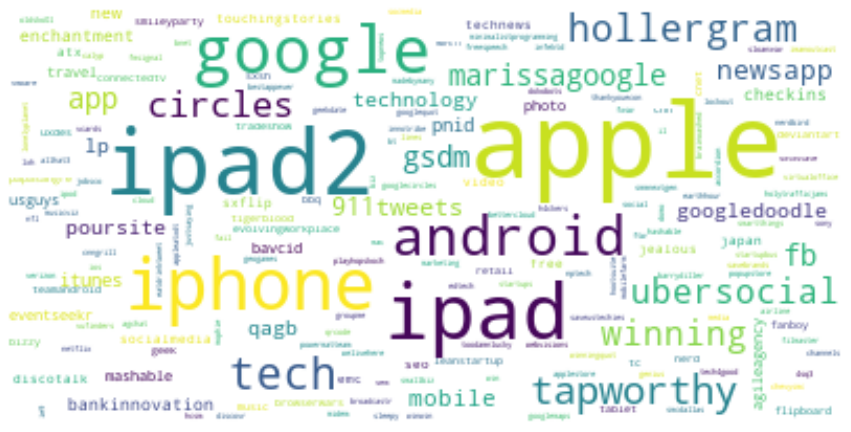

In [24]:
# Most commonly used hashtag against positive sentiment

wordcloud = WordCloud(background_color="white",max_font_size=50,stopwords=stop_words,collocations=False).generate(str(dataset[dataset['sentiment']==2]['clean_hashtag']))

# Display the generated image:
plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

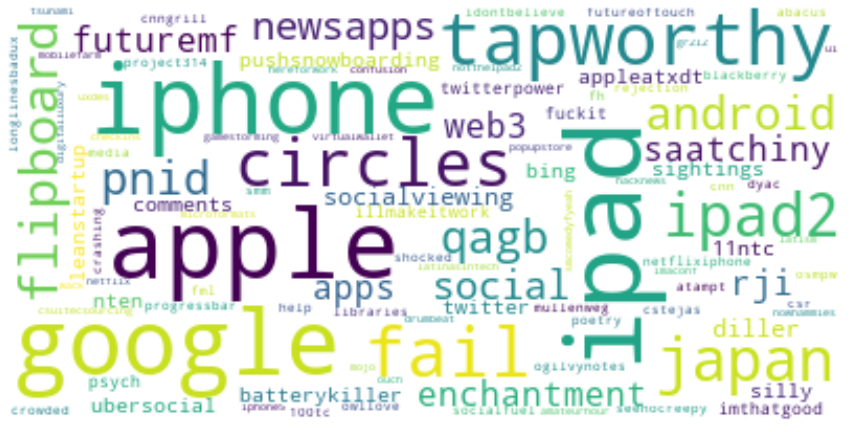

In [25]:
# Most commonly used hashtag against negative sentiment

wordcloud = WordCloud(background_color="white",max_font_size=50,stopwords=stop_words,collocations=False).generate(str(dataset[dataset['sentiment']==0]['clean_hashtag']))

# Display the generated image:
plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

So nothing worth could be understood basis just hashtag as it is associated with company/product. Lets try with Adjective and Noun to understand expressive words as well as product/company/platform.

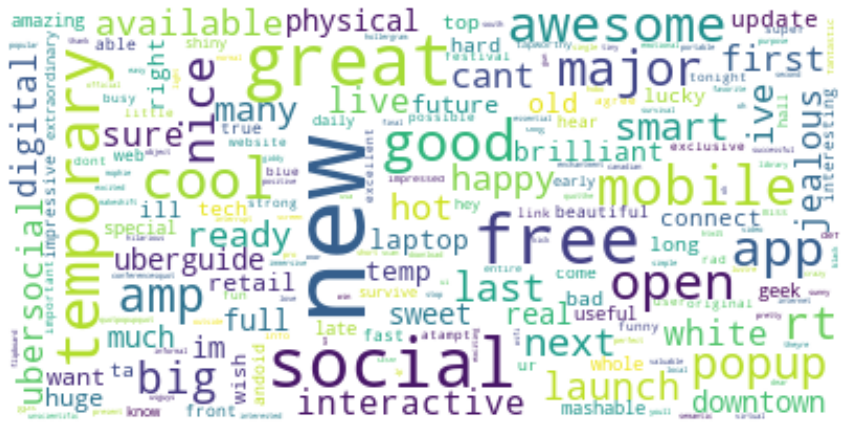

In [26]:
# Most commonly used adjectives against positive sentiment

wordcloud = WordCloud(background_color="white",max_font_size=50,stopwords=stop_words,collocations=False).generate(str(dataset[dataset['sentiment']==2]['tweet_adj']))

# Display the generated image:
plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

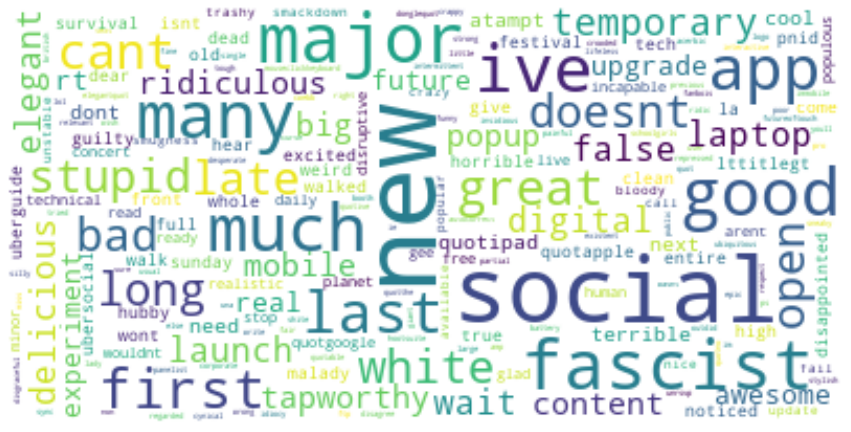

In [27]:
# Most commonly used adjectives against negative sentiment

wordcloud = WordCloud(background_color="white",max_font_size=50,stopwords=stop_words,collocations=False).generate(str(dataset[dataset['sentiment']==0]['tweet_adj']))

# Display the generated image:
plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

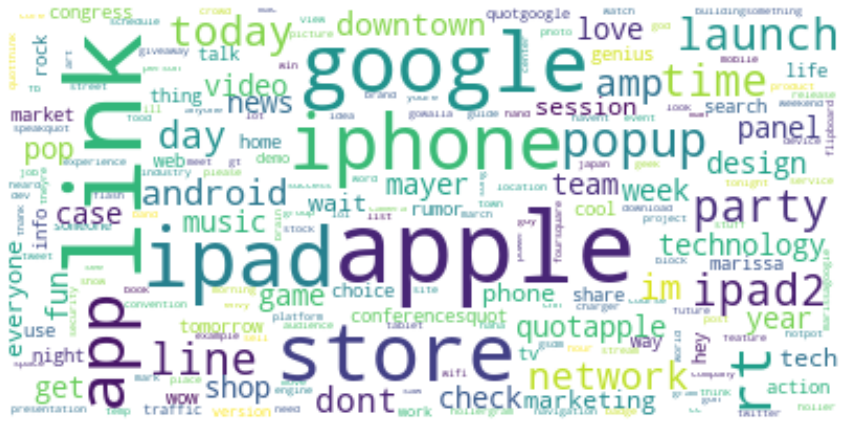

In [28]:
# Most commonly used noun against positive sentiment

wordcloud = WordCloud(background_color="white",max_font_size=50,stopwords=stop_words,collocations=False).generate(str(dataset[dataset['sentiment']==2]['tweet_noun']))

# Display the generated image:
plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

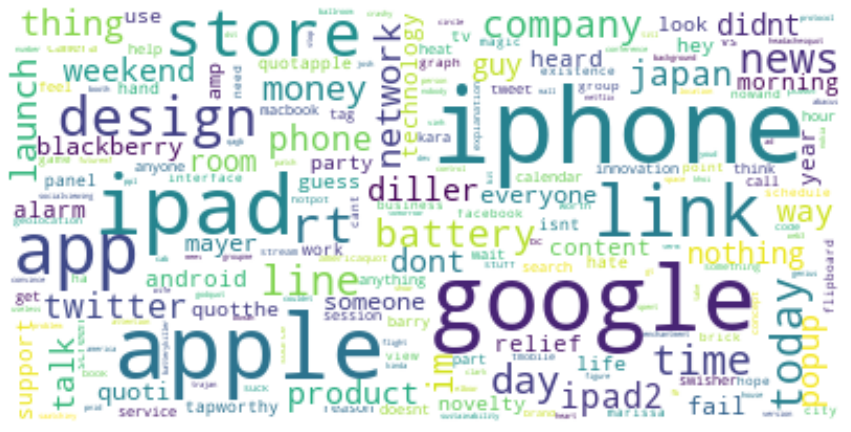

In [29]:
# Most commonly used noun against negative sentiment

wordcloud = WordCloud(background_color="white",max_font_size=50,stopwords=stop_words,collocations=False).generate(str(dataset[dataset['sentiment']==0]['tweet_noun']))

# Display the generated image:
plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Vectorization

In [30]:
# Bag of words technique with Unigram
bow = CountVectorizer(binary=False, max_df=0.95,ngram_range=(1,1),analyzer = "word")
dataset_bow = bow.fit_transform(dataset['clean_tweet'])
dataset_bow

<7273x9486 sparse matrix of type '<class 'numpy.int64'>'
	with 69930 stored elements in Compressed Sparse Row format>

# Model Building - Logistic Regression

In [31]:
# splitting data into training and validation set
X_train,X_test,y_train,y_test = train_test_split(dataset_bow, dataset['sentiment'], random_state=7, test_size=0.3)

lreg = LogisticRegression(verbose=1, solver='liblinear',random_state=0, C=5, penalty='l2',max_iter=1000,multi_class='auto')
lreg.fit(X_train, y_train) # training the model

# predicting on the validation set

y_pred = cross_val_predict(lreg, X_test, y_test, cv=10)
print(classification_report(y_test, y_pred))
print("ACCURACY::", accuracy_score(y_pred, y_test))

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]              precision    recall  f1-score   support

           0       0.57      0.21      0.30       150
           1       0.68      0.81      0.74      1303
           2       0.54      0.44      0.49       701
           3       0.00      0.00      0.00        28

    accuracy                           0.64      2182
   macro avg       0.45      0.36      0.38      2182
weighted avg       0.62      0.64      0.62      2182

ACCURACY:: 0.6402383134738772


# Model Building - RandomForest

In [32]:
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train) # training the model

# predicting on the validation set

y_pred = cross_val_predict(rfc, X_test, y_test, cv=10)
print(classification_report(y_test, y_pred))
print("ACCURACY::", accuracy_score(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.70      0.14      0.23       150
           1       0.64      0.92      0.76      1303
           2       0.61      0.24      0.35       701
           3       0.00      0.00      0.00        28

    accuracy                           0.64      2182
   macro avg       0.49      0.33      0.33      2182
weighted avg       0.63      0.64      0.58      2182

ACCURACY:: 0.6388634280476627


# Vectorization and Model Building

In [33]:
dataset_1 = pd.DataFrame(bow.fit_transform(dataset['clean_tweet']).toarray(),columns=bow.get_feature_names())

dataset_2 = pd.DataFrame(bow.fit_transform(dataset['clean_hashtag']).toarray(),columns=bow.get_feature_names())

dataset_3 = pd.DataFrame(bow.fit_transform(dataset['tweet_noun']).toarray(),columns=bow.get_feature_names())

dataset_4 = pd.DataFrame(bow.fit_transform(dataset['tweet_adj']).toarray(),columns=bow.get_feature_names())

dataset_bow = pd.concat([dataset_1,dataset_2,dataset_3,dataset_4], axis=1)


In [34]:
dataset_bow.shape

(7273, 17381)

In [35]:
# splitting data into training and validation set
X_train,X_test,y_train,y_test = train_test_split(dataset_bow, dataset['sentiment'], random_state=7, test_size=0.3)

lreg = LogisticRegression(verbose=1, solver='liblinear',random_state=0, C=5, penalty='l2',max_iter=1000,multi_class='auto')
lreg.fit(X_train, y_train) # training the model

# predicting on the validation set

y_pred = cross_val_predict(lreg, X_test, y_test, cv=10)
print(classification_report(y_test, y_pred))
print("ACCURACY::", accuracy_score(y_pred, y_test))

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]              precision    recall  f1-score   support

           0       0.50      0.19      0.27       150
           1       0.68      0.80      0.73      1303
           2       0.52      0.44      0.48       701
           3       0.00      0.00      0.00        28

    accuracy                           0.63      2182
   macro avg       0.42      0.36      0.37      2182
weighted avg       0.61      0.63      0.61      2182

ACCURACY:: 0.6287809349220899


In [36]:
# with bigram

bow = CountVectorizer(binary=False, max_df=0.95,ngram_range=(1,2),analyzer = "word")

dataset_1 = pd.DataFrame(bow.fit_transform(dataset['clean_tweet']).toarray(),columns=bow.get_feature_names())

dataset_2 = pd.DataFrame(bow.fit_transform(dataset['clean_hashtag']).toarray(),columns=bow.get_feature_names())

dataset_3 = pd.DataFrame(bow.fit_transform(dataset['tweet_noun']).toarray(),columns=bow.get_feature_names())

dataset_4 = pd.DataFrame(bow.fit_transform(dataset['tweet_adj']).toarray(),columns=bow.get_feature_names())

dataset_bow = pd.concat([dataset_1,dataset_2,dataset_3,dataset_4], axis=1)

X_train,X_test,y_train,y_test = train_test_split(dataset_bow, dataset['sentiment'], random_state=7, test_size=0.3)

lreg = LogisticRegression(verbose=1, solver='liblinear',random_state=0, C=5, penalty='l2',max_iter=1000,multi_class='auto')
lreg.fit(X_train, y_train) # training the model

# predicting on the validation set

y_pred = cross_val_predict(lreg, X_test, y_test, cv=10)
print(classification_report(y_test, y_pred))
print("ACCURACY::", accuracy_score(y_pred, y_test))

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]              precision    recall  f1-score   support

           0       0.57      0.17      0.26       150
           1       0.67      0.84      0.75      1303
           2       0.54      0.40      0.46       701
           3       0.00      0.00      0.00        28

    accuracy                           0.64      2182
   macro avg       0.45      0.35      0.37      2182
weighted avg       0.62      0.64      0.61      2182

ACCURACY:: 0.6393217231897342


In [37]:
# with trigrams

bow = CountVectorizer(binary=False, max_df=0.95,ngram_range=(1,3),analyzer = "word")

dataset_1 = pd.DataFrame(bow.fit_transform(dataset['clean_tweet']).toarray(),columns=bow.get_feature_names())

dataset_2 = pd.DataFrame(bow.fit_transform(dataset['clean_hashtag']).toarray(),columns=bow.get_feature_names())

dataset_3 = pd.DataFrame(bow.fit_transform(dataset['tweet_noun']).toarray(),columns=bow.get_feature_names())

dataset_4 = pd.DataFrame(bow.fit_transform(dataset['tweet_adj']).toarray(),columns=bow.get_feature_names())

dataset_bow = pd.concat([dataset_1,dataset_2,dataset_3,dataset_4], axis=1)

X_train,X_test,y_train,y_test = train_test_split(dataset_bow, dataset['sentiment'], random_state=7, test_size=0.3)

lreg = LogisticRegression(verbose=1, solver='liblinear',random_state=0, C=5, penalty='l2',max_iter=1000,multi_class='auto')
lreg.fit(X_train, y_train) # training the model

# predicting on the validation set

y_pred = cross_val_predict(lreg, X_test, y_test, cv=10)
print(classification_report(y_test, y_pred))
print("ACCURACY::", accuracy_score(y_pred, y_test))

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]              precision    recall  f1-score   support

           0       0.57      0.14      0.22       150
           1       0.67      0.85      0.75      1303
           2       0.55      0.38      0.45       701
           3       0.00      0.00      0.00        28

    accuracy                           0.64      2182
   macro avg       0.45      0.34      0.36      2182
weighted avg       0.61      0.64      0.61      2182

ACCURACY:: 0.6388634280476627


# Word Embedding Vectorization

In [73]:
#list_of_list = dataset['clean_tweet'].tolist()
list_of_list = dataset['clean_tweet'].apply(lambda x: x.split()).tolist()

print (list_of_list)

[['apple', 'defining', 'language', 'touch', 'different', 'dialects', 'becoming', 'smaller'], ['learning', 'ab', 'google', 'doodles', 'doodles', 'light', 'funny', 'amp', 'innovative', 'exceptions', 'significant', 'occasions', 'googledoodle'], ['one', 'inyourface', 'ex', 'stealing', 'show', 'yrs', 'rt', 'quotat', 'apple', 'schools', 'mkt', 'expertsquot', 'link'], ['iphone', 'app', 'would', 'b', 'pretty', 'awesome', 'didnt', 'crash', 'every', '10mins', 'extended', 'browsing', 'fuckit', 'illmakeitwork'], ['line', 'outside', 'apple', 'store', 'waiting', 'new', 'ipad', 'link'], ['technews', 'one', 'lone', 'dude', 'awaits', 'ipad', '2', 'apples', 'store', 'link', 'technews', 'apple', 'ipad2', 'tablets', 'tech'], ['tips', 'prince', 'npr', 'videos', 'toy', 'shopping', 'zuckerberglink', 'ipad'], ['nu', 'user', 'rt', 'new', 'ubersocial', 'iphone', 'app', 'store', 'includes', 'uberguide', 'sponsored', 'mashable'], ['free', 'sampler', 'itunes', 'link', 'freemusic'], ['think', 'might', 'go', 'weeken

In [75]:
#providing input to Word2Vect in required list of list format
word_embd = Word2Vec(list_of_list,size=100, window=5, min_count=1, workers=4)
word_embd.most_similar('apple')

/Users/pritigirishvankudre/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


[('pop', 0.9994420409202576),
 ('shop', 0.9993575215339661),
 ('open', 0.9993014931678772),
 ('temp', 0.9985292553901672),
 ('congress', 0.9976481199264526),
 ('core', 0.9970717430114746),
 ('opened', 0.9961564540863037),
 ('store', 0.9960293769836426),
 ('geekfest', 0.9956372976303101),
 ('sixth', 0.9952540397644043)]

In [76]:
word_embd.most_similar('google')

/Users/pritigirishvankudre/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('programming', 0.9979201555252075),
 ('socialmedia', 0.9973909854888916),
 ('debut', 0.9972372055053711),
 ('googlecircles', 0.9968623518943787),
 ('new', 0.995374321937561),
 ('preview', 0.9953523874282837),
 ('cnet', 0.9952948689460754),
 ('screw', 0.9933714866638184),
 ('today', 0.9931014180183411),
 ('secret', 0.9929724335670471)]

In [80]:
# For positive sentiment, find out word embedding
positive_senti = dataset[dataset['sentiment']==2]['clean_tweet'].apply(lambda x: x.split()).tolist()
positive_word_embd = Word2Vec(positive_senti,size=100, window=5, min_count=1, workers=4)
positive_word_embd.most_similar('apple')

/Users/pritigirishvankudre/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  after removing the cwd from sys.path.


[('link', 0.9997919797897339),
 ('ipad', 0.9997671842575073),
 ('rt', 0.999755859375),
 ('amp', 0.9997435808181763),
 ('iphone', 0.9997249841690063),
 ('android', 0.9997107982635498),
 ('ipad2', 0.9997092485427856),
 ('store', 0.9997032880783081),
 ('like', 0.9996914267539978),
 ('google', 0.9996861815452576)]